## Fashion-MNIST-based simulated production line prediction
<font color=#FF0000>Description, TO BE DONE!!</font>

### Packages import

In [1]:
# necessary packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# additional certain short functions
from torch import is_tensor
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy
from math import floor, ceil
from torch import stack
from torch import cat

# import custom functions
from data_generate import *
from data_io import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\shuang07\.conda\envs\auto_labeling\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Custom data loading

In [3]:
# Customize dataset
class ProductLineDataset(Dataset):
    def __init__(self, image: torch.Tensor, gt: torch.Tensor):
        self.x = image.reshape(len(image), 1, 28*3, 28*4).type(torch.float32)
        self.y = gt.type(torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### <font color=#FF0000>Visualization reference (non-used yet) <font>

#### single bounding box testing 

In [19]:
def box(col, row, box_x, box_y):    # position + length / width (visualization usage)
    view = torch.zeros([28*3, 28*4], dtype=torch.float32)
    # set the box, outside the target with one pixel
    view[row-box_y:row+1, col-box_x] = 1
    view[row-box_y:row+1, col] = 1
    view[row-box_y, col-box_x:col+1] = 1
    view[row, col-box_x:col+1] = 1
    return view

new start position [x, y] = [ 14 , 71 ]


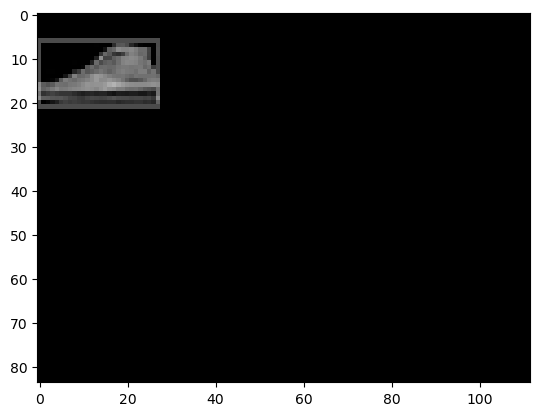

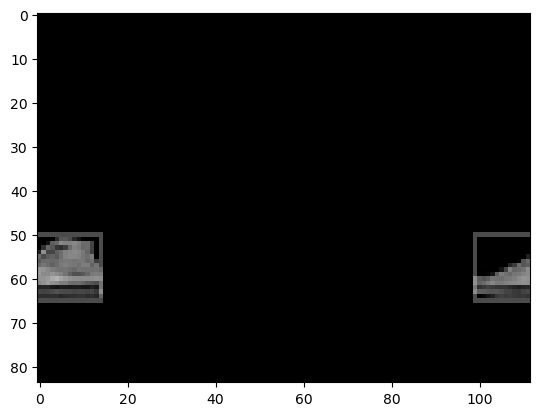

In [20]:
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy

rand_x = randint(14, 27)
rand_y = randint(27, 28*3-1)
print("new start position [x, y] = [", rand_x,",", rand_y, "]")

rand_start = deepcopy(aug_sample)
box_origin = box(27, 21, 27, 15)    # array for visualization, the only manual input part
box_sample = deepcopy(box_origin)

plt.imshow(rand_start, cmap='gray')
plt.imshow(box_origin, cmap='gray', alpha=0.3)
pause(0.1)

# initial movement
for i in range(28):
    for j in range(28):
        rand_start[rand_y-i][rand_x-j] = rand_start[27-i][27-j]

for i in range(29):
    for j in range(29):
        box_origin[rand_y-i+1][rand_x-j+1] = box_origin[28-i][28-j]

# clean other part
rand_start[:rand_y-28+1, :] = 0
rand_start[:, rand_x+1:rand_x+28+1] = 0
box_origin[:rand_y-28, :] = 0       # 1-pixel cleaning region difference
box_origin[:, rand_x+1:rand_x+28+1] = 0

plt.imshow(rand_start, cmap='gray')
plt.imshow(box_origin, cmap='gray', alpha=0.3)
pause(0.1)


#### sequential bounding box visualization and random position

In [24]:
from math import floor, ceil
from torch import cat
import matplotlib.pyplot as plt
from matplotlib.pyplot import pause
from copy import deepcopy

sequential box preparation

torch.Size([84, 112])


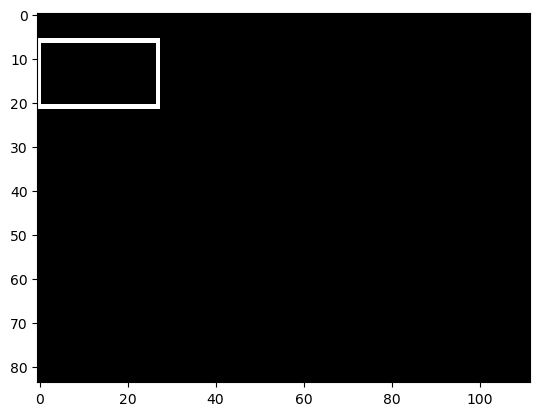

In [25]:
# initialization
stride = 5
first_frame = deepcopy(box_sample)
next_frame = deepcopy(box_sample)
y_box = deepcopy(box_sample)

# show info
print(y_box.size())
plt.imshow(y_box, cmap='gray')
pause(0.1)

for i in range(floor((112-28)/stride)):
   # moving part (1-dim only)
   for j in range(30):  # bigger range to cover bounding box
      next_frame[:, 30+stride*(i+1)-(j+1)] = next_frame[:, 30+stride*i-(j+1)]
   next_frame[:, :stride*(i+1)] = 0  # clean other area
   
   # sequencing part
   if i == 0:
      y_box = stack((first_frame, next_frame)) 
   else:
      y_box = cat((y_box, next_frame.reshape(1, 28*3, 28*4)), dim=0)
      
   # # show info
   # print(y_box.size())
   # plt.imshow(y_box[i+1], cmap='gray')
   # pause(0.1)

parallel moving and concat last frames

new start position [x, y] = [ 23 , 75 ]


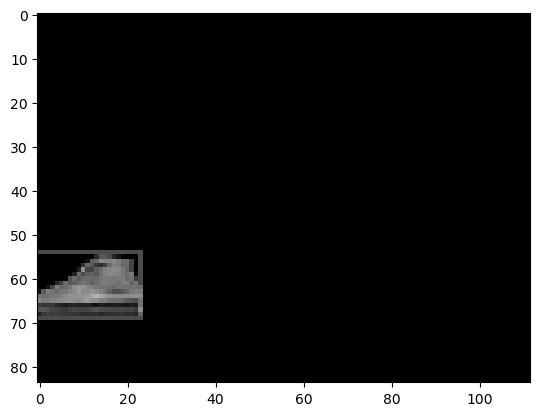

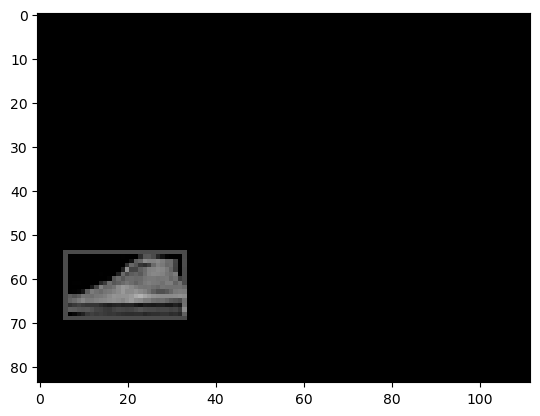

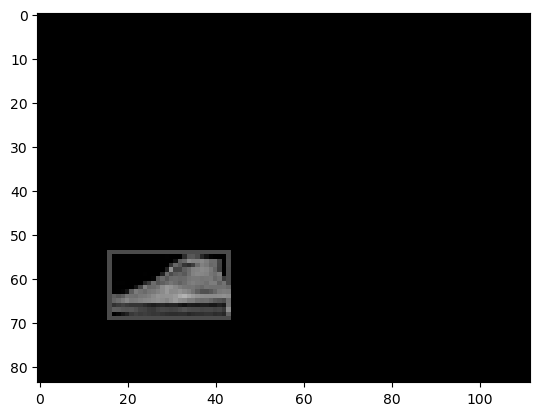

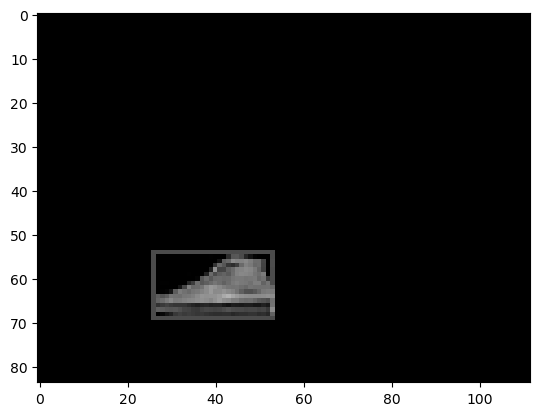

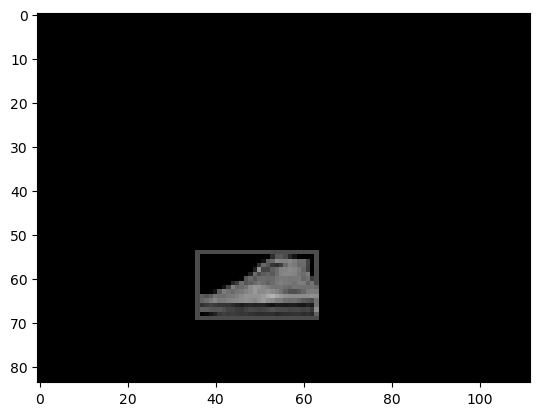

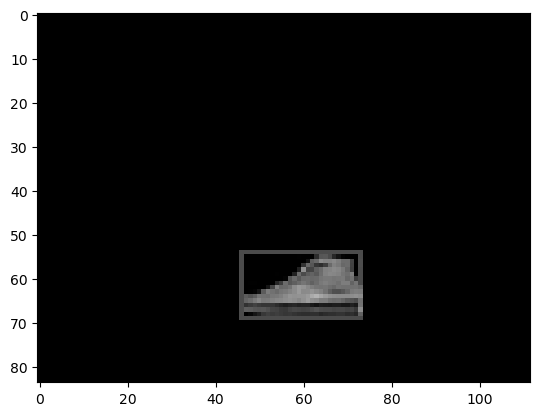

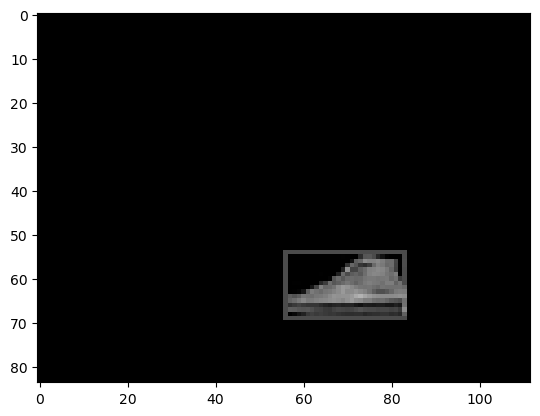

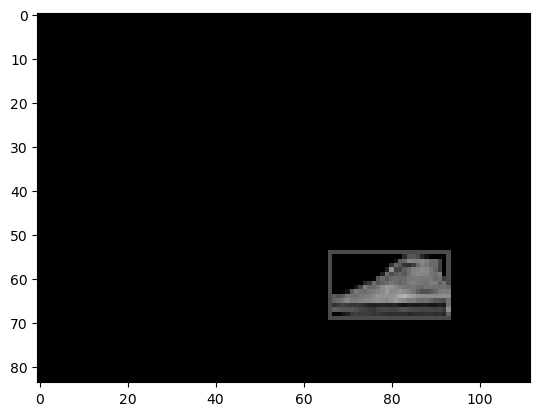

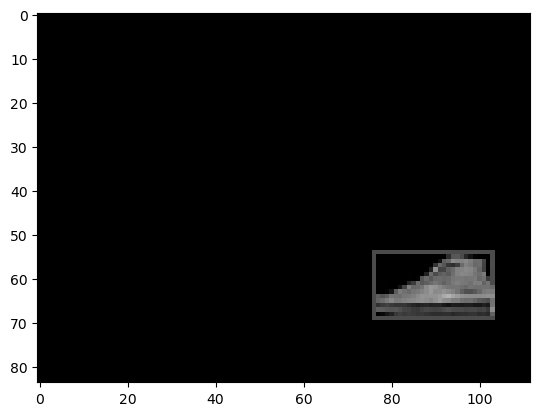

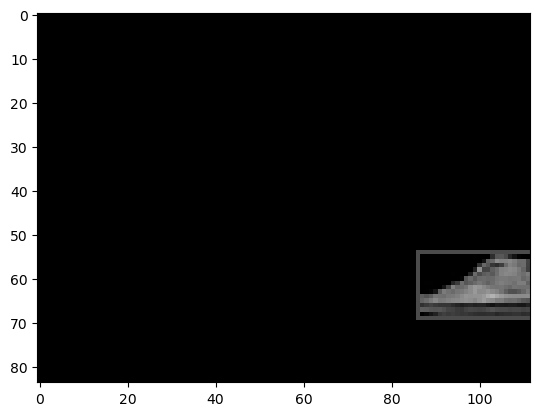

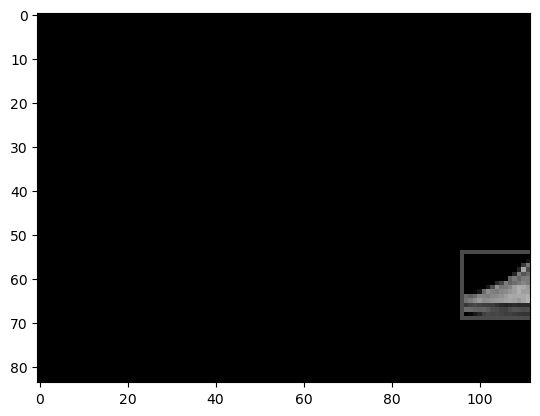

torch.Size([11, 84, 112])


In [26]:
# sequential data preparation
y_box_moved = deepcopy(y_box)
y_moved = deepcopy(y)
rand_x = randint(14, 27)
rand_y = randint(27, 28*3-1)
print("new start position [x, y] = [", rand_x,",", rand_y, "]")

# # visualization for no parallel movement
# for i in range(len(y_box_moved)):
#     plt.imshow(y_moved[i], cmap='gray')
#     plt.imshow(y_box_moved[i], cmap='gray', alpha=0.3)
#     pause(0.1)

# all frames move left parellel
for i in range(floor((112-28)/stride)+1): 
    # moving items
    for j in range(28):
        for k in range(28):
            y_moved[i][rand_y-j][rand_x+stride*i-k] = y_moved[i][27-j][27+stride*i-k]
    # moving box
    for j in range(29):
        for k in range(29):
            y_box_moved[i][rand_y-j+1][rand_x+stride*i-k+1] = y_box_moved[i][28-j][28+stride*i-k]
          
    # clean other area
    y_moved[i][:rand_y-28+1, :] = 0
    y_moved[i][:, rand_x+stride*i+1:] = 0
    y_box_moved[i][:rand_y-28+1, :] = 0
    y_box_moved[i][:, rand_x+stride*i+1:] = 0
   
    # show info
    plt.imshow(y_moved[i], cmap='gray')
    plt.imshow(y_box_moved[i], cmap='gray', alpha=0.3)
    pause(0.1)

# initialization
frame_old = len(y_moved)   # number of old frames
next_frame = deepcopy(y_moved[frame_old-1])
next_frame_box = deepcopy(y_box_moved[frame_old-1])

# last frame moves right and cat
for i in range(ceil((28-rand_x)/stride)+1):
    # move next frame
    for j in range(28):
        if rand_x+stride*(frame_old+i)-j < 112:
           next_frame[:, rand_x+stride*(frame_old+i)-j] = next_frame[:, rand_x+stride*(frame_old+i-1)-j]
    for j in range(29):
        if rand_x+stride*(frame_old+i)-j+1 < 112:
           next_frame_box[:, rand_x+stride*(frame_old+i)-j+1] = next_frame_box[:, rand_x+stride*(frame_old+i-1)-j+1]
    # clean and cat
    next_frame[:, :rand_x+stride*(frame_old+i)-28+1] = 0
    y_moved = cat((y_moved, next_frame.reshape(1, 28*3, 28*4)), dim=0)
    next_frame_box[:, :rand_x+stride*(frame_old+i)-28+1] = 0
    y_box_moved = cat((y_box_moved, next_frame_box.reshape(1, 28*3, 28*4)), dim=0)
   
    # show info
    plt.imshow(y_moved[frame_old+i], cmap='gray')
    plt.imshow(y_box_moved[frame_old+i], cmap='gray', alpha=0.3)
    pause(0.1)

print(y_moved.size())